# Actividad 1: Deep Vision
__Carlos Esteban Posada__  
contacto: crls.esteban@hotmail.com


## Descripción de la actividad

En esta actividad, el alumno debe evaluar y comparar dos estrategias para la clasificación de imágenes en el dataset Caltech 101. El dataset ha sido preprocesado y guardado utilizando pickle (más información sobre el preprocesado se puede obtener en el notebook "preprocesado_caltech101.ipynb").

Las instrucciones de cómo obtener el dataset aparecen al inicio de este notebook.

### * Estrategia 1: Red pre-entrenada

La primera estrategia a comparar debe incluir la utilización de una red preentrenada con el dataset ImageNet, llevando a cabo tareas de *transfer learning* y *fine-tuning* para clasificar los objetos de Caltech 101. Deben compararse al menos dos tipos de arquitecturas (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe seleccionar la que mayor precisión nos dé (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera que el alumno utilice todas las técnicas de optimización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).

### * Estrategia 2: Entrenar desde cero o *from scratch*

La segunda estrategia a comparar será una red neuronal profunda que el alumno debe diseñar, entrenar y optimizar. Se debe justificar empíricamente las decisiones que llevaron a la selección de atributos, capas e hiperparámetros a los que se ha llegado. Se espera que el alumno utilice todas las técnicas de optimización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).

### * Normas a seguir

- Se debe entregar un **ÚNICO COLAB notebook** que incluya las instrucciones presentes y su **EJECUCIÓN!!!**. Debe aparecer todo el proceso seguido (i.e. carga de datos, visualización de datos, proceso de entrenamiento y proceso de validación del modelo).
- El notebook, junto a cualquier archivo necesario, __deberá entregarse como un link compartido__ en una carpeta gdrive.
- Tanto __la carga de archivos como guardar datos a archivos__ deberán siempre __contener referencias parciales__ con respecto a un directorio base (__BASE_FOLDER__).  En este notebook se incluye un ejemplo de cómo cargar datos utilizando un directorio base.
- Aunque los alumnos pueden trabajar en sus propios ordenadores, __la entrega deberá hacerse como un notebook en google colaboratory__, de forma que el profesor pueda abrir y ejecutar el código desde Google Colab sin necesitar alteraciones (salvo el cambio de BASE_FOLDER).
- Las __redes utilizadas deben estar entrenadas. La entrega de una red sin entrenar supondrá perdida de puntos.
- Si se desea __evidenciar alguna métrica__ del proceso de entrenamiento (precisión, pérdida, etc.), estas deben ser generadas.
- Todos los archivos que deban adjuntarse a la actividad __deberán incluirse en la carpeta gdrive compartida__, y el notebook debe hacer referencias parciales a los mismos.
- Es recomendable crear una última sección de texto en el Notebook en la que se discutan los diferentes modelos obtenidos y se extraigan las conclusiones pertinentes.




## Criterio de evaluación

- Seguimiento de las normas establecidas en la actividad.
- Efectividad al presentar las comparaciones entre métricas de evaluación de ambos modelos.
- Demostración de la utilización de técnicas de optimización para mejorar el rendimiento de los modelos.
- Modelos predictivos con rendimiento superior al aleatorio.
- Corrección en el uso de algoritmos, modelos y formas idiomáticas en Python.
- Se deberá incluir mediante un link de acceso público, tanto el notebook como cualquier archivo que se utilice en el mismo. En el notebook se deberán cargar los modelos a través de estos archivos.
- El código debe poder ejecutarse sin modificación alguna (salvo el cambio de BASE_FOLDER) en Google Colaboratory.

## Carga, pre-procesamiento y separación de los datos
En esta sección se cargarán las imágenes y se procederá a un preprocesamiento para poder ejecutar los algoritmos.
También se separará la data en 3 conjuntos:
* train: será usado para entrenar todos los modelos
* validation: será usado para validar todos los modelos y ajustar hiperparámetros
* test: será usado para verificar la capacidad de generalización de cada modelo

### Carga de los datos

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tarfile
import pickle
import time
%matplotlib inline

# Include all packages
from tensorflow.keras.applications import VGG16, Xception, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import imagenet_utils
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D

In [ ]:
# Configuracion Drive
###################################################################################################
# La utilizacion de un directorio base es obligatoria
# Todas las referencias al disco duro (guardar o cargar) deberan tener esta variable como base
###################################################################################################
BASE_FOLDER = '/content/drive/My Drive/07_MAIR_DEEP_LEARNING_ACTIVIDAD/'
###################################################################################################

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# verificar que el BASE_FOLDER está bien montado
os.listdir(BASE_FOLDER) 

['pickle_all_classes.pickle',
 'df.pickle',
 'preprocesado_caltech101.ipynb',
 'pickle_all_images_df.pickle',
 'deepCNN_CIFAR10_pretrained.h5',
 '07MAIR_Actividad 1.ipynb',
 'Copia de Trasfer learning y data aug 25G .ipynb',
 'solucion_actividad.ipynb',
 'metricas_df.csv']

In [ ]:
# Cargamos imagenes
###################################################################################################
# Ejemplo de como cargar de archivos con referencia al directorio base
###################################################################################################
# DESCARGAR Y DESCOMPRIMIR EL DATASET CALTECH_PREPROCESADO DEL GDRIVE
# Cargar las ndarrays

with open(BASE_FOLDER+"pickle_all_images_df.pickle", "rb") as input_file:
    X_orig = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_orig = pickle.load(input_file)

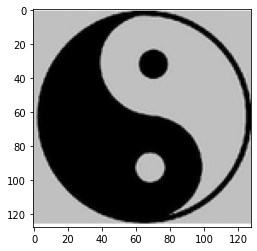

In [ ]:
# show image: verificar el contenido de alguna imagen
imgplot = plt.imshow(X_orig[9098])
plt.show()

### Pre-procesamiento de las imágenes
Las imágenes vienen en un formato ya escaladas entre 0-1. 
Las devolveremos a su tamaño original (multiplicando x 255) y luego procedemos a hacer el preprocess de imagenet_utils.

In [ ]:
# Las imágenes ya vienen en rango [0,1]. Se llevan a 255 para proceder a hacer 
# el procesamiento de imagenet
X = X_orig*255

X = imagenet_utils.preprocess_input(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


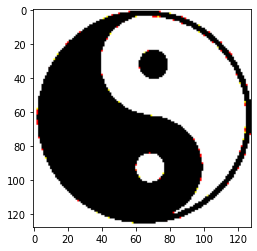

In [ ]:
# show image
imgplot = plt.imshow(X[9098])
plt.show()

### Pre-procesamiento de las etiquetas

In [ ]:
labels = list(set(y_orig))
labels.sort()
# print(labels)

In [ ]:
#One-hot encoding a las categorías
lb = LabelBinarizer()
y_lb = lb.fit_transform(y_orig)

### Separación de los datos

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y_lb, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(6401, 128, 128, 3)
(1372, 128, 128, 3)
(1372, 128, 128, 3)


In [ ]:
# borramos la data X e y_lb para liberar memoria ram
try:
    del X
    del y_lb
except:
    pass

### Creación de ImageGenerator
Crearemos un objeto de ImageGenerator para generar más datos haciendo ligeras modificaciones a las imágenes que tenemos. Esto nos ayudará con el sobre entrenamiento de los modelos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=40, # grados de rotacion aleatoria
                            width_shift_range=0.2, # fraccion del total (1) para mover la imagen
                            height_shift_range=0.2, # fraccion del total (1) para mover la imagen
                            horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
                            zoom_range=0.2, # rango de zoom
                            validation_split = 0.2,
)

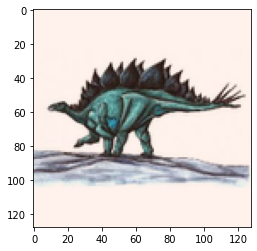

Label = cellphone


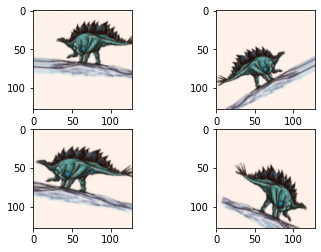

In [ ]:
# inspeccionar muestra con data aumentation
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

sample = 2303
plt.imshow(image.array_to_img(X_train[sample]))
plt.show()

print('Label = {}'.format(y_orig[sample]))

fig, axes = plt.subplots(2,2)
i = 0
for batch in datagen.flow(X_train[sample].reshape((1,128,128,3)),batch_size=1):
    #plt.figure(i)
    axes[i//2,i%2].imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

### Funciones auxiliares
A continuación se implementarán una serie de funciones que serán útiles en el resto del notebook. Esto con el objetivo de reutilizar código

In [ ]:
def graficar_entrenamiento(H):
    # Función para graficar las métricas de entrenamiento de un modelo.
    # Recibe: 
    # H: el objeto con el histórico de entrenamiento del modelo de keras
    #    es retornado por el .fit del modelo

    EPOCHS = len(H.epoch)

    # Gráficas
    plt.figure(figsize=(20, 5))
    # plt.style.use("ggplot")
    
    # subplot del Loss
    plt.subplot(121)
    plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()


    plt.subplot(122)
    plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()

    # show figure
    plt.show()


In [ ]:
def accuracy_mine(target, prediction):
    # función para evaluar el accuracy entre una matriz target y la matriz predicción
    sum_correctos = np.sum(target.argmax(axis=1) == prediction.argmax(axis=1))
    return sum_correctos/len(target)

In [ ]:
# Objeto necesario para guardar las métricas
metricas_df = pd.DataFrame(columns=["model_name", "train_acc", "val_acc", "test_acc", "trainable_params", "non_trainable_params", "training_time"])
metricas_df

,model_name,train_acc,val_acc,test_acc,trainable_params,non_trainable_params,training_time


In [ ]:
def evaluar_modelo(model, X_train, y_train, X_val, y_val, X_test, y_test, model_details, metricas_df):
    # Esta función evalúa un modelo 'model'
    # y guardará los resultados en el dataframe de metricas 'metricas_df'
    # el parámetro 'model_details' es un diccionario que contendrá:
    #  ** model_name, non_trainable_params, trainable_params, training_time

    print("######### 1. Making predictions ######### ")
    print()
    print("Predicting on train set")
    y_train_pred = model.predict(X_train, batch_size=128) 

    print("Predicting on val set")
    y_val_pred = model.predict(X_val, batch_size=128)

    print("Predicting on test set")
    y_test_pred = model.predict(X_test, batch_size=128)

    print()
    
    print("######### 2. Computing metrics ######### ")
    print("computing metrics on train set")
    train_acc = accuracy_mine(y_train, y_train_pred)
    print(train_acc)
    print("computing metrics on val set")
    val_acc = accuracy_mine(y_val, y_val_pred)
    print(val_acc)
    print("computing metrics on test set")
    test_acc = accuracy_mine(y_test, y_test_pred)
    print(test_acc)

    # guardar los resultados en el dataframe
    print()
    print("######### saving results on: metricas_df #########")
    registro_dict = {
        "model_name": model_details.get("name"), 
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc, 
        "trainable_params": model_details.get("trainable"),
        "non_trainable_params": model_details.get("non_trainable"),
        "training_time": model_details.get("training_time")
    }
    metricas_df = metricas_df.append(registro_dict, ignore_index=True)
    return metricas_df

## Solución con red pre-entrenada.
En las siguientes secciones se implementarán redes pre-entrenadas cargando sus arquitecturas y pesos y luego procediendo a hacer transfer learning / fine tunning para adaptarlas anuestro problema particular

### ResNet50

In [ ]:
model_details= {
    "name": "ResNet50 + 256 + 102"
}

#### Cargar base model

In [ ]:
base_model = ResNet50(weights='imagenet',
                 include_top=False, # No incluir el top model, i.e. la parte densa destinada a la clasificación (fully connected layers)
                 input_shape=(128,128,3))
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Agregar top model

In [ ]:
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(102, activation='softmax'))

pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               26214     
Total params: 32,002,790
Trainable params: 8,415,078
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# se guardan más datos para el reporte final
model_details["trainable"] = 8_415_078
model_details["non_trainable"] = 23_587_712

#### Compilar y entrenar el modelo

In [ ]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(lr=0.0005,decay=0,
                          beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) 
print("[INFO]: Modelo Compilado con exito")


[INFO]: Compilando el modelo...
[INFO]: Modelo Compilado con exito


In [ ]:
# Entrenamiento de la red
start_time = time.time()
print("[INFO]: Entrenando la red...")
EPOCHS = 50
BATCH_SIZE = 128
H_aug = pre_trained_model.fit(
    datagen.flow(X_train, y_train, batch_size=128, subset='training'),
    steps_per_epoch = int(len(X_train)*0.8)/ 128,epochs=EPOCHS,
    validation_data=datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, subset='validation'))


# Se guarda el tiempo de entrenamiento
elapsed_time = time.time()-start_time

model_details["training_time"] = elapsed_time

[INFO]: Entrenando la red...
Epoch 1/50
40/40 [==============================] - 26s 528ms/step - loss: 5.1501 - accuracy: 0.2899 - val_loss: 2.3153 - val_accuracy: 0.5036
Epoch 2/50
40/40 [==============================] - 20s 493ms/step - loss: 1.8491 - accuracy: 0.5869 - val_loss: 1.5798 - val_accuracy: 0.6277
Epoch 3/50
40/40 [==============================] - 20s 489ms/step - loss: 1.2367 - accuracy: 0.7105 - val_loss: 1.6913 - val_accuracy: 0.6715
Epoch 4/50
40/40 [==============================] - 20s 489ms/step - loss: 0.9213 - accuracy: 0.7700 - val_loss: 1.5340 - val_accuracy: 0.6825
Epoch 5/50
40/40 [==============================] - 20s 491ms/step - loss: 0.8566 - accuracy: 0.7820 - val_loss: 1.3588 - val_accuracy: 0.7153
Epoch 6/50
40/40 [==============================] - 19s 486ms/step - loss: 0.6674 - accuracy: 0.8228 - val_loss: 1.4680 - val_accuracy: 0.7044
Epoch 7/50
40/40 [==============================] - 20s 487ms/step - loss: 0.6101 - accuracy: 0.8378 - val_loss: 

#### Evaluar el modelo

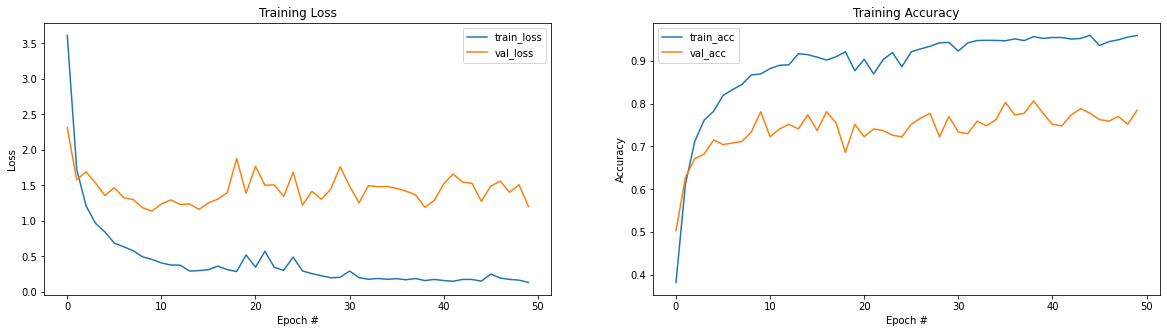

In [ ]:
graficar_entrenamiento(H_aug)

In [ ]:
metricas_df= evaluar_modelo(pre_trained_model, X_train, y_train, X_val, y_val, X_test, y_test, model_details, metricas_df)
metricas_df.to_csv(BASE_FOLDER+"metricas_df.csv", index=False)
metricas_df

######### 1. Making predictions ######### 

Predicting on train set
Predicting on val set
Predicting on test set

######### 2. Computing metrics ######### 
computing metrics on train set
0.9517262927667552
computing metrics on val set
0.8440233236151603
computing metrics on test set
0.8440233236151603

######### saving results on: metricas_df #########


,model_name,train_acc,val_acc,test_acc,trainable_params,non_trainable_params,training_time
0,ResNet50 + 256 + 102,0.951726,0.844023,0.844023,8415078,23587712,999.155373


### VGG16

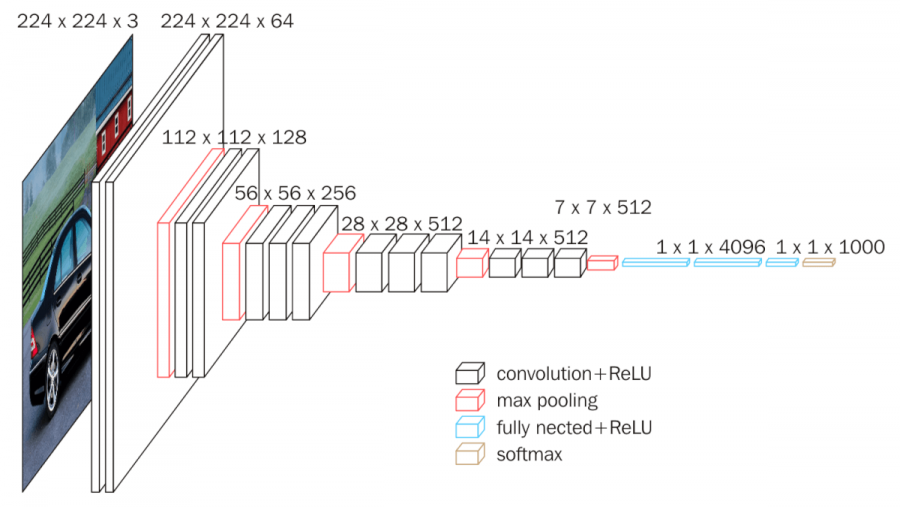

In [ ]:
# Arquitectura
from IPython.core.display import Image, display
display(Image(BASE_FOLDER+'vgg16-1-e1542731207177.png', width=900, unconfined=True))

In [ ]:
model_details= {
    "name": "VGG16 + 256 + 102",   
}

#### Cargar base model

In [ ]:
base_model = VGG16(weights='imagenet',
                 include_top=False, # No incluir el top model, i.e. la parte densa destinada a la clasificación (fully connected layers)
                 input_shape=(128,128,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

#### Agregar top model

In [ ]:
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(102, activation='softmax'))

pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 102)               26214     
Total params: 16,838,310
Trainable params: 2,123,622
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# se guardan más datos para el reporte final
model_details["trainable"] = 2_123_622
model_details["non_trainable"] = 14_714_688

#### Compilar y entrenar el modelo

In [ ]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(lr=0.0005,decay=0,
                          beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) 
print("[INFO]: Modelo Compilado con exito")

[INFO]: Compilando el modelo...
[INFO]: Modelo Compilado con exito


In [ ]:
# Entrenamiento de la red
start_time = time.time()
print("[INFO]: Entrenando la red...")
EPOCHS = 50
BATCH_SIZE = 128
H_aug = pre_trained_model.fit(
    datagen.flow(X_train, y_train, batch_size=128, subset='training'),
    steps_per_epoch = int(len(X_train)*0.8)/ 128,epochs=EPOCHS,
    validation_data=datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, subset='validation'))


# Se guarda el tiempo de entrenamiento
elapsed_time = time.time()-start_time

model_details["training_time"] = elapsed_time

[INFO]: Entrenando la red...
Epoch 1/50
40/40 [==============================] - 25s 523ms/step - loss: 11.3789 - accuracy: 0.2507 - val_loss: 2.8571 - val_accuracy: 0.4051
Epoch 2/50
40/40 [==============================] - 20s 491ms/step - loss: 2.6620 - accuracy: 0.4287 - val_loss: 2.4870 - val_accuracy: 0.5182
Epoch 3/50
40/40 [==============================] - 20s 492ms/step - loss: 2.0769 - accuracy: 0.5445 - val_loss: 2.2132 - val_accuracy: 0.5365
Epoch 4/50
40/40 [==============================] - 20s 487ms/step - loss: 1.7670 - accuracy: 0.6074 - val_loss: 1.9462 - val_accuracy: 0.5803
Epoch 5/50
40/40 [==============================] - 20s 495ms/step - loss: 1.4560 - accuracy: 0.6722 - val_loss: 2.2897 - val_accuracy: 0.5803
Epoch 6/50
40/40 [==============================] - 20s 496ms/step - loss: 1.3278 - accuracy: 0.7084 - val_loss: 1.9227 - val_accuracy: 0.6314
Epoch 7/50
40/40 [==============================] - 20s 491ms/step - loss: 1.1711 - accuracy: 0.7271 - val_loss:

#### Evaluar el modelo

[INFO]: Evaluando el modelo...
                   precision    recall  f1-score   support

BACKGROUND_Google       0.60      0.63      0.61        79
            Faces       1.00      1.00      1.00        53
       Faces_easy       1.00      1.00      1.00        59
         Leopards       0.84      1.00      0.91        26
       Motorbikes       0.99      1.00      1.00       115
        accordion       1.00      0.80      0.89        10
        airplanes       0.98      0.97      0.98       123
           anchor       0.57      0.57      0.57         7
              ant       0.33      0.50      0.40         4
           barrel       1.00      0.67      0.80        12
             bass       1.00      0.55      0.71        11
           beaver       1.00      0.33      0.50         6
        binocular       0.83      0.83      0.83         6
           bonsai       1.00      0.87      0.93        15
            brain       0.86      0.90      0.88        20
     brontosaurus       

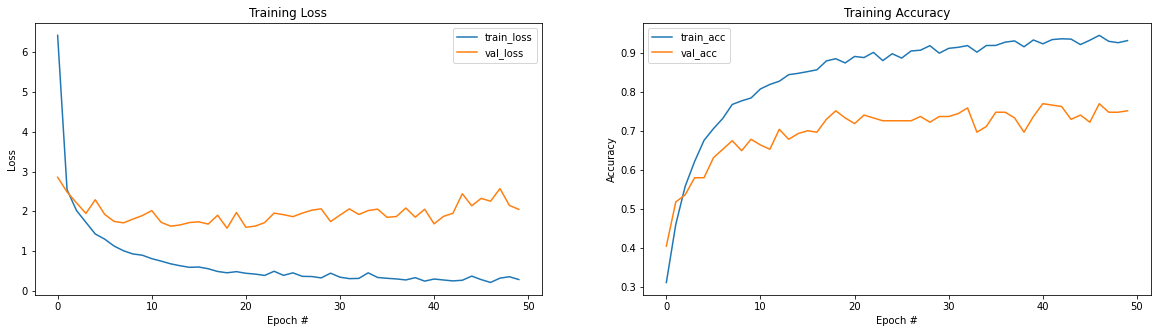

In [ ]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(X_val, batch_size=128) 
# Sacamos el report para test
print(classification_report(y_val.argmax(axis=1), predictions.argmax(axis=1), target_names=labels)) 

graficar_entrenamiento(H_aug)

In [ ]:
metricas_df= evaluar_modelo(pre_trained_model, X_train, y_train, X_val, y_val, X_test, y_test, model_details, metricas_df)
metricas_df.to_csv(BASE_FOLDER+"metricas_df.csv", index=False)
metricas_df

######### 1. Making predictions ######### 

Predicting on train set
Predicting on val set
Predicting on test set

######### 2. Computing metrics ######### 
computing metrics on train set
0.9493829089204812
computing metrics on val set
0.8338192419825073
computing metrics on test set
0.8185131195335277

######### saving results on: metricas_df #########


,model_name,train_acc,val_acc,test_acc,trainable_params,non_trainable_params,training_time
0,ResNet50 + 256 + 102,0.951726,0.844023,0.844023,8415078,23587712,999.155373
1,VGG16 + 256 + 102,0.949383,0.833819,0.818513,2123622,14714688,987.628844


### Fine tuning

#### Cargar base model
Se cargará como basemodel un VGG16

In [ ]:
model_details = {
    "name": "VGG16 + fine_tuning + dropout + weight_reg"    
}

In [ ]:
base_model = VGG16(weights='imagenet',
                 include_top=False, # No incluir el top model, i.e. la parte densa destinada a la clasificación (fully connected layers)
                 input_shape=(128,128,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

#### Congelar capas del base_model

In [ ]:
# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers: 
  if layer.name == 'block5_conv3': 
    break 
  layer.trainable = False 
  print('Capa ' + layer.name + ' congelada...') 

Capa input_3 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Capa block4_conv1 congelada...
Capa block4_conv2 congelada...
Capa block4_conv3 congelada...
Capa block4_pool congelada...
Capa block5_conv1 congelada...
Capa block5_conv2 congelada...


#### Agregar top model

In [ ]:
# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output 
x = Flatten()(last) 
# x = Dropout(0.3)(x) 
x = Dense(128, activation='relu', name='fc1', kernel_regularizer="l2")(x)
x = Dropout(0.3)(x) 
# x = Dense(128, activation='relu', name='fc2', kernel_regularizer="l2")(x)
# x = Dropout(0.3)(x) 
# x = Dense(128, activation='relu', name='fc2', kernel_regularizer="l2")(x) 
# x = Dropout(0.3)(x)
x = Dense(102, activation='softmax', name='predictions')(x) 
fine_tunned_model = Model(base_model.input, x) 

In [ ]:
fine_tunned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
# se guardan más datos para el reporte final
model_details["trainable"] = 3_421_670
model_details["non_trainable"] = 12_354_880

#### Compilar y entrenar el modelo

In [ ]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")
fine_tunned_model.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(lr=0.0005,decay=0,
                          beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) 
print("[INFO]: Modelo Compilado con exito")

[INFO]: Compilando el modelo...
[INFO]: Modelo Compilado con exito


In [ ]:
# Entrenamiento de la red
start_time = time.time()
print("[INFO]: Entrenando la red...")
EPOCHS = 50
BATCH_SIZE= 128
H_fine_tunned = fine_tunned_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
    steps_per_epoch = len(X_train)*0.8//BATCH_SIZE, #int(len(X_train)*0.8)/ 128,
    epochs=EPOCHS,
    validation_data=datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, subset='validation'))

# Se guarda el tiempo de entrenamiento
elapsed_time = time.time()-start_time

model_details["training_time"] = elapsed_time




[INFO]: Entrenando la red...
Epoch 1/50
40/40 [==============================] - 21s 501ms/step - loss: 12.6066 - accuracy: 0.1377 - val_loss: 5.8687 - val_accuracy: 0.3066
Epoch 2/50
40/40 [==============================] - 19s 469ms/step - loss: 5.9434 - accuracy: 0.2844 - val_loss: 5.4839 - val_accuracy: 0.3431
Epoch 3/50
40/40 [==============================] - 19s 473ms/step - loss: 5.5660 - accuracy: 0.3051 - val_loss: 5.1477 - val_accuracy: 0.3321
Epoch 4/50
40/40 [==============================] - 19s 470ms/step - loss: 5.2077 - accuracy: 0.3302 - val_loss: 4.9388 - val_accuracy: 0.3394
Epoch 5/50
40/40 [==============================] - 19s 468ms/step - loss: 4.9123 - accuracy: 0.3370 - val_loss: 4.7975 - val_accuracy: 0.3321
Epoch 6/50
40/40 [==============================] - 19s 471ms/step - loss: 4.6484 - accuracy: 0.3473 - val_loss: 4.4152 - val_accuracy: 0.3613
Epoch 7/50
40/40 [==============================] - 19s 467ms/step - loss: 4.4007 - accuracy: 0.3720 - val_loss:

#### Evaluar el modelo

In [ ]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = fine_tunned_model.predict(X_val, batch_size=128) 
# Sacamos el report para test
print(classification_report(y_val.argmax(axis=1), predictions.argmax(axis=1), target_names=labels)) 

[INFO]: Evaluando el modelo...
                   precision    recall  f1-score   support

BACKGROUND_Google       0.63      0.73      0.68        79
            Faces       1.00      1.00      1.00        53
       Faces_easy       1.00      1.00      1.00        59
         Leopards       0.90      1.00      0.95        26
       Motorbikes       1.00      1.00      1.00       115
        accordion       0.62      1.00      0.77        10
        airplanes       0.98      0.96      0.97       123
           anchor       0.71      0.71      0.71         7
              ant       0.33      0.25      0.29         4
           barrel       0.90      0.75      0.82        12
             bass       0.50      0.36      0.42        11
           beaver       0.43      0.50      0.46         6
        binocular       1.00      0.67      0.80         6
           bonsai       0.88      0.93      0.90        15
            brain       0.78      0.90      0.84        20
     brontosaurus       

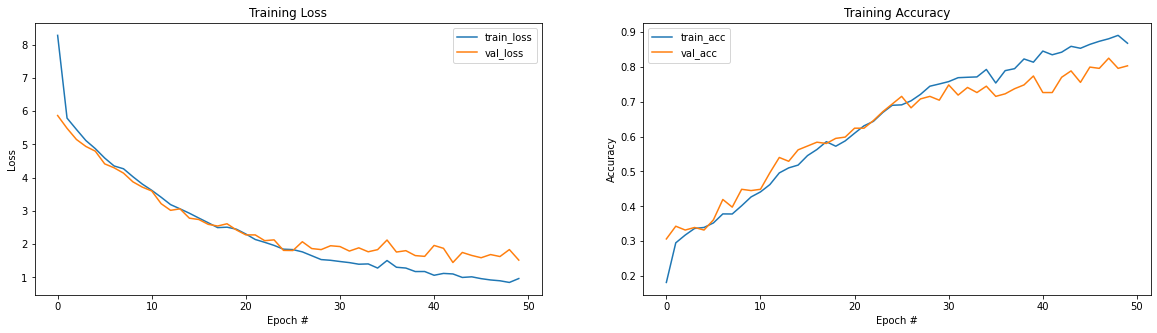

In [ ]:
graficar_entrenamiento(H_fine_tunned)

In [ ]:
metricas_df= evaluar_modelo(fine_tunned_model, X_train, y_train, X_val, y_val, X_test, y_test, model_details, metricas_df)
metricas_df.to_csv(BASE_FOLDER+"metricas_df.csv", index=False)
metricas_df

######### 1. Making predictions ######### 

Predicting on train set
Predicting on val set
Predicting on test set

######### 2. Computing metrics ######### 
computing metrics on train set
0.9273551007655054
computing metrics on val set
0.847667638483965
computing metrics on test set
0.8316326530612245

######### saving results on: metricas_df #########


,model_name,train_acc,val_acc,test_acc,trainable_params,non_trainable_params,training_time
0,ResNet50 + 256 + 102,0.951726,0.844023,0.844023,8415078,23587712,999.155373
1,VGG16 + 256 + 102,0.949383,0.833819,0.818513,2123622,14714688,987.628844
2,VGG16 + fine_tuning + dropout + weight_reg,0.927355,0.847668,0.831633,3421670,12354880,964.382557


## Neural Network from scratch

El siguiente modelo se ajustó para mejorar el accuracy y a su vez no terminar en un modelo sobre entrenado. 

Los ajustes fueron:
* Reducción del número de parámetros: Se redujo el número de parámetros entrenables por medio de varias capas convolucionales con maxpooling, dado que solo se cuenta con al rededor de 9000 imágenes para entrenar y validar. Por lo tanto un modelo de mucha complejidad terminaría sobre entrenándose de manera muy fácil. 

* Dropout: se agregaron capas de dropout con el fin de disminuir el overfitting, lo cual funcionó pues el modelo original obtenía al rededor de 45% de accuracy en train y 60 en validation. 


### Arquitectura del modelo

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
# se construirá una red neuronal from scratch
mynet = Sequential()

# Base model
mynet.add(layers.Conv2D(32, (3,3), input_shape=(128, 128, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.MaxPooling2D((2,2)))
mynet.add(Dropout(0.05))

mynet.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.MaxPooling2D((2,2)))
mynet.add(Dropout(0.05))

mynet.add(layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.MaxPooling2D((2,2)))
mynet.add(Dropout(0.05))

mynet.add(layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(layers.MaxPooling2D((2,2)))
mynet.add(Dropout(0.05))



# TOP model
mynet.add(layers.Flatten())
mynet.add(Dropout(0.5))

mynet.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
mynet.add(Dropout(0.5))

mynet.add(layers.Dense(102, activation='softmax'))

In [ ]:
mynet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)       

In [ ]:
model_details = {
    "name": "convolutional from_scratch", 
    "trainable": 2_247_302,
    "non_trainable":0
}

### Compilar y entrenar el modelo

In [ ]:
mynet.compile(optimizer='adam',
               loss='categorical_crossentropy',
               #loss='categorical_crossentropy', #If labels are one-hot encoded
               metrics=['accuracy'])

In [ ]:
# Entrenamiento de la red
start_time = time.time()
print("[INFO]: Entrenando la red...")
epochs = 50
H_aug = mynet.fit(
    datagen.flow(X_train, y_train, batch_size=128, subset='training'),
    steps_per_epoch = int(len(X_train)*0.8)/ 128,epochs=epochs,
    validation_data=datagen.flow(X_val, y_val, batch_size=128, subset='validation'))


# Se guarda el tiempo de entrenamiento
elapsed_time = time.time()-start_time

model_details["training_time"] = elapsed_time


[INFO]: Entrenando la red...
Epoch 1/50
40/40 [==============================] - 22s 493ms/step - loss: 6.2264 - accuracy: 0.0675 - val_loss: 4.7720 - val_accuracy: 0.0693
Epoch 2/50
40/40 [==============================] - 19s 478ms/step - loss: 4.7722 - accuracy: 0.0772 - val_loss: 4.7427 - val_accuracy: 0.0803
Epoch 3/50
40/40 [==============================] - 19s 482ms/step - loss: 4.7163 - accuracy: 0.0809 - val_loss: 4.6122 - val_accuracy: 0.0803
Epoch 4/50
40/40 [==============================] - 19s 477ms/step - loss: 4.5594 - accuracy: 0.1174 - val_loss: 4.4304 - val_accuracy: 0.1460
Epoch 5/50
40/40 [==============================] - 19s 486ms/step - loss: 4.4079 - accuracy: 0.1756 - val_loss: 4.3377 - val_accuracy: 0.1934
Epoch 6/50
40/40 [==============================] - 19s 479ms/step - loss: 4.2836 - accuracy: 0.1890 - val_loss: 4.1295 - val_accuracy: 0.2445
Epoch 7/50
40/40 [==============================] - 19s 485ms/step - loss: 4.1502 - accuracy: 0.2350 - val_loss: 

### Evaluar el modelo

In [ ]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = mynet.predict(X_val, batch_size=128) 
# Sacamos el report para test
print(classification_report(y_val.argmax(axis=1), predictions.argmax(axis=1), target_names=labels)) 


[INFO]: Evaluando el modelo...
                   precision    recall  f1-score   support

BACKGROUND_Google       0.12      0.62      0.20        79
            Faces       0.77      0.96      0.86        53
       Faces_easy       0.74      0.97      0.84        59
         Leopards       0.39      0.88      0.54        26
       Motorbikes       0.70      0.97      0.81       115
        accordion       0.00      0.00      0.00        10
        airplanes       0.84      0.98      0.90       123
           anchor       0.00      0.00      0.00         7
              ant       0.00      0.00      0.00         4
           barrel       0.00      0.00      0.00        12
             bass       0.00      0.00      0.00        11
           beaver       0.00      0.00      0.00         6
        binocular       0.00      0.00      0.00         6
           bonsai       0.33      0.07      0.11        15
            brain       0.00      0.00      0.00        20
     brontosaurus       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


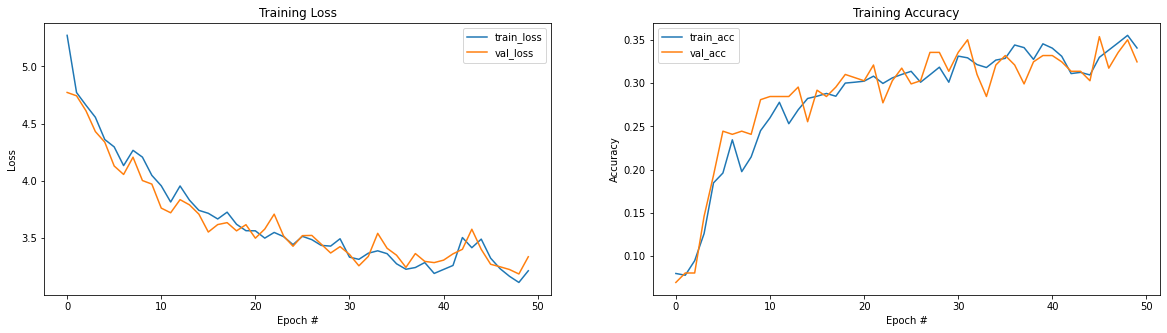

In [ ]:
graficar_entrenamiento(H_aug)

In [ ]:
metricas_df= evaluar_modelo(mynet, X_train, y_train, X_val, y_val, X_test, y_test, model_details, metricas_df)
metricas_df.to_csv(BASE_FOLDER+"metricas_df.csv", index=False)
metricas_df

######### 1. Making predictions ######### 

Predicting on train set
Predicting on val set
Predicting on test set

######### 2. Computing metrics ######### 
computing metrics on train set
0.4022808936103734
computing metrics on val set
0.38411078717201164
computing metrics on test set
0.3870262390670554

######### saving results on: metricas_df #########


,model_name,train_acc,val_acc,test_acc,trainable_params,non_trainable_params,training_time
0,ResNet50 + 256 + 102,0.951726,0.844023,0.844023,8415078,23587712,999.155373
1,VGG16 + 256 + 102,0.949383,0.833819,0.818513,2123622,14714688,987.628844
2,VGG16 + fine_tuning + dropout + weight_reg,0.927355,0.847668,0.831633,3421670,12354880,964.382557
3,convolutional from_scratch,0.402281,0.384111,0.387026,2247302,0,971.436431


## Conclusiones

In [ ]:
display(metricas_df)

,model_name,train_acc,val_acc,test_acc,trainable_params,non_trainable_params,training_time
0,ResNet50 + 256 + 102,0.951726,0.844023,0.844023,8415078,23587712,999.155373
1,VGG16 + 256 + 102,0.949383,0.833819,0.818513,2123622,14714688,987.628844
2,VGG16 + fine_tuning + dropout + weight_reg,0.927355,0.847668,0.831633,3421670,12354880,964.382557
3,convolutional from_scratch,0.402281,0.384111,0.387026,2247302,0,971.436431


En este trabajo analizamos 4 redes neuronales diferentes para abordar el problema.

De estas, podemos destacar:
* ResNet50 es la que tiene más parámetros y tardó más en entrenar (todas entrenaron 50 épocas). Sus resultados fueron ligeramente mejores que los de VGG 16, pero a un costo computacional que en mi opinión no vale la pena. 

* Por el motivo anterior, se decidió continuar trabajando con VGG16 y hacer un siguiente paso: fine tuning. 
Este Fine tuning resultó entregar los mejores resultados entre todos, pues es el modelo que más precisión tuvo en val y test y a su vez el que menos sobre entrenamiento presentó.
Para que funcionara bien tocó reducir mucho la capa final, para tener pocos pesos entrenables, pues por el número de imágenes disponibles, era necesario tener pocos trainable parameters para evitar sobre entrenamiento. 

* La red neuronal from scratch tuvo un desempeño inferior a las demás, era de esperarse pues se contó con un poco más de 6000 imágenes para clasificar 102 clases diferentes. Lo interesante acá fue jugar con los hiper-parámetros, pues el principal obstáculo fue el sobre entrenamiento. Resultó muy fácil hacer que la red se "aprendiera" de memoria las imágenes del training set. Por este motivo opté por reducir precisión en training con tal de aumentar accuracy en val y test y se logró, pues en los 3 conjuntos se obtuvo accuracy de aproximadamente 0.39.